# Predicción del estrés financiero

# Librerías

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from sklearn import datasets
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, train_test_split, validation_curve
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

from statsmodels.stats.outliers_influence import variance_inflation_factor


%matplotlib inline

# Carga del dataset

In [2]:
#pip install openpyxl

In [3]:
dataset = pd.read_excel('../data/product/product-ffu.xlsx', engine='openpyxl')

dataset

,TD_div_TA,WC_div_TA,EBITDA_div_TA,lnTA,isFamiliar,z_cat
0,0.625639,0.191468,0.030919,19.710178,0,1
1,0.140025,0.292908,0.178364,18.660925,0,0
2,0.221861,0.370248,0.090879,18.385202,1,0
3,0.635556,0.292989,0.064907,17.903484,1,1
4,0.294878,0.317507,0.026602,17.891653,1,0
...,...,...,...,...,...,...
196,0.764067,0.069767,0.046522,12.719271,1,0
197,0.701952,0.434562,0.239619,11.976667,1,0
198,0.517596,0.512058,0.196798,12.290730,1,0
199,0.286977,0.344796,-0.077330,13.866345,1,1


In [4]:
X = pd.DataFrame(dataset[dataset.columns[:-1]])
Y = dataset[dataset.columns[-1]]

In [5]:
X.head()

,TD_div_TA,WC_div_TA,EBITDA_div_TA,lnTA,isFamiliar
0,0.625639,0.191468,0.030919,19.710178,0
1,0.140025,0.292908,0.178364,18.660925,0
2,0.221861,0.370248,0.090879,18.385202,1
3,0.635556,0.292989,0.064907,17.903484,1
4,0.294878,0.317507,0.026602,17.891653,1


In [6]:
Y.head()

0    1
1    0
2    0
3    1
4    0
Name: z_cat, dtype: int64

# Semilla

In [7]:
myseed=1234

# Métricas

In [8]:
from sklearn.metrics import make_scorer
from sklearn.metrics import average_precision_score, recall_score

recall_scorer = make_scorer(recall_score, pos_label=1,labels=[0,1])
spec_scorer = make_scorer(recall_score, pos_label=0,labels=[0,1])
pr_auc_scorer = make_scorer(average_precision_score)

accuracy = []
f1 = []
precision = []
recall = []
spec=[]
roc_auc = []
prec_rec = []

dicci = {"accuracy":"accuracy", "average_precision":pr_auc_scorer,
         "f1":"f1", "precision":"precision", "recall":recall_scorer,
         "spec":spec_scorer,"roc_auc":"roc_auc"}

def score(scores):
    accuracy.append(str(np.around(np.mean(scores.get("test_accuracy")),3)) + " ("
                + str(np.around(np.std(scores.get("test_accuracy")), 3))+ ")")
    f1.append(str(np.around(np.mean(scores.get("test_f1")),3)) + " ("
                + str(np.around(np.std(scores.get("test_f1")), 3))+ ")")
    precision.append(str(np.around(np.mean(scores.get("test_precision")),3)) + " ("
                + str(np.around(np.std(scores.get("test_precision")), 3))+ ")")
    recall.append(str(np.around(np.mean(scores.get("test_recall")),3)) + " ("
                + str(np.around(np.std(scores.get("test_recall")), 3))+ ")")
    spec.append(str(np.around(np.mean(scores.get("test_spec")),3)) + " ("
                + str(np.around(np.std(scores.get("test_spec")), 3))+ ")")
    roc_auc.append(str(np.around(np.mean(scores.get("test_roc_auc")),3)) + " ("
                + str(np.around(np.std(scores.get("test_roc_auc")), 3))+ ")")

# Regresión logística

Los algoritmos ya tienen integrados la validación cruzada estratificada, una vez limpien los datos y elaboren las variables. Prueben con este para empezar

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate

#solvers = ['liblinear','lbfgs','saga','sag']
#penal = ['l1','l2','elasticnet']
logistic = LogisticRegressionCV(random_state=myseed, max_iter=200, solver='liblinear',penalty='l1')
scaler = StandardScaler()
scores = cross_validate(logistic, X,Y, cv=10, scoring=dicci)
score(scores)
scores

{'fit_time': array([0.32041788, 0.19454718, 0.15751314, 0.17185307, 0.17706013,
        0.1773982 , 0.181247  , 0.17426062, 0.28736615, 0.23310423]),
 'score_time': array([0.02175164, 0.02505517, 0.01894569, 0.01809144, 0.01979089,
        0.0218761 , 0.0209856 , 0.12858868, 0.03229094, 0.01986551]),
 'test_accuracy': array([0.85714286, 0.8       , 0.8       , 0.85      , 0.9       ,
        0.85      , 0.9       , 0.85      , 0.75      , 0.8       ]),
 'test_average_precision': array([0.69047619, 0.60714286, 0.62857143, 0.63333333, 0.75      ,
        0.63333333, 0.74444444, 0.63333333, 0.48095238, 0.525     ]),
 'test_f1': array([0.8       , 0.66666667, 0.6       , 0.72727273, 0.85714286,
        0.72727273, 0.83333333, 0.72727273, 0.61538462, 0.6       ]),
 'test_precision': array([0.75      , 0.8       , 1.        , 0.8       , 0.75      ,
        0.8       , 0.83333333, 0.8       , 0.57142857, 0.75      ]),
 'test_recall': array([0.85714286, 0.57142857, 0.42857143, 0.66666667, 1. 

In [10]:
from sklearn.model_selection import cross_val_predict
logistic = LogisticRegressionCV(random_state=myseed, max_iter=200, solver='liblinear',penalty='l1')
scaler = StandardScaler()
prediccioneslogistic = cross_val_predict(logistic, X,Y, cv=10)
prediccioneslogisticproba = cross_val_predict(logistic, X,Y, cv=10, method="predict_proba")

# Random Forest

La idea básica del bagging es utilizar el conjunto de entrenamiento original para generar centenares o miles de conjuntos similares usando muestreo con reemplazo. En este concepto está basado el algoritmo Random Forest, la combinación de varios árboles de decisión, cada uno entrenado con una realización diferente de los datos. La decisión final del clasificador combinado (el Random Forest) se toma por mayoría, dando el mismo peso a todas las decisiones parciales tomadas por los clasificadores base (los árboles).

In [11]:
#depth = [10,25,50,75,100,125]
#estimadores= [1000]

rfc = RandomForestClassifier(random_state=myseed, max_depth=32, n_estimators=954)
scoresrfc = cross_validate(rfc, X, Y, cv=10, scoring=dicci)
score(scoresrfc)
scoresrfc

{'fit_time': array([1.87249303, 1.99455404, 2.00615239, 2.0642097 , 1.94193935,
        1.96132135, 1.99099517, 1.92501307, 1.94392085, 1.96601987]),
 'score_time': array([0.20285702, 0.23874021, 0.20092607, 0.21115065, 0.217942  ,
        0.21426821, 0.22182846, 0.22357345, 0.18934774, 0.20059681]),
 'test_accuracy': array([0.80952381, 0.85      , 0.85      , 0.75      , 0.9       ,
        0.75      , 0.85      , 0.75      , 0.75      , 0.65      ]),
 'test_average_precision': array([0.6       , 0.6952381 , 0.6952381 , 0.42222222, 0.75      ,
        0.45      , 0.65      , 0.45      , 0.48095238, 0.33333333]),
 'test_f1': array([0.66666667, 0.76923077, 0.76923077, 0.44444444, 0.85714286,
        0.54545455, 0.66666667, 0.54545455, 0.61538462, 0.36363636]),
 'test_precision': array([0.8       , 0.83333333, 0.83333333, 0.66666667, 0.75      ,
        0.6       , 1.        , 0.6       , 0.57142857, 0.4       ]),
 'test_recall': array([0.57142857, 0.71428571, 0.71428571, 0.33333333, 1. 

In [12]:
rfc = RandomForestClassifier(random_state=myseed, max_depth=32, n_estimators=954)
prediccionesrfc = cross_val_predict(rfc, X, Y, cv=10)
prediccionesrfcproba = cross_val_predict(rfc, X,Y, cv=10, method="predict_proba")

# KNN

In [13]:
#algoritmo = ['auto','ball_tree','kd_tree','brute']
#p = [1,2]
#metric = ['euclidean','manhattan','chebyshev','minkowski','wminkowski','seuclidean','mahalanobis']

neigh = KNeighborsClassifier(n_neighbors=2, algorithm='auto',p=1, weights="distance")
scoresneigh = cross_validate(neigh, X, Y, cv=10, scoring=dicci)
score(scoresneigh)
scoresneigh
print(str(np.around(np.mean(scoresneigh['test_roc_auc']),3)))

0.788


In [14]:
neigh = KNeighborsClassifier(n_neighbors=2, algorithm='auto',p=1, weights="distance")
prediccionesneigh = cross_val_predict(neigh, X, Y, cv=10)
prediccionesneighproba = cross_val_predict(neigh, X,Y, cv=10, method="predict_proba")

# SVM

In [15]:
from sklearn.model_selection import cross_validate
#kernels = ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed']
#C = [1.0,5.0,10.0,50.0,100.0]
#gammas = [0.1,0.01,0.05,0.001,0.005]

svm = SVC(gamma=0.0023420730885665587,probability=True, C=55.56346718268796)
scoressvm = cross_validate(svm, X, Y, cv=10, scoring=dicci)
score(scoressvm)
print(str(np.around(np.mean(scoressvm['test_f1']),3)))
print(str(np.around(np.mean(scoressvm['test_spec']),3)))
print(str(np.around(np.mean(scoressvm['test_roc_auc']),3)))

0.57
0.935
0.885


In [16]:
svm = SVC(gamma=0.0023420730885665587,probability=True, C=55.56346718268796)
prediccionessvm = cross_val_predict(svm, X, Y, cv=10)
prediccionessvmproba = cross_val_predict(svm, X, Y, cv=10, method="predict_proba")

# Resultados

In [17]:
conjunto1 = pd.DataFrame(columns=["accuracy", "f1_score", "precision","recall","specificity","roc_auc"])
conjunto1["accuracy"] = accuracy
conjunto1["f1_score"] = f1
conjunto1["precision"] = precision
conjunto1["recall"] = recall
conjunto1["specificity"] = spec
conjunto1["roc_auc"] = roc_auc
conjunto1.index = ["LOGIT","RFC", "KNN","SVM"]
#conjunto1.to_csv("conjunto1.csv")

In [18]:
conjunto1

,accuracy,f1_score,precision,recall,specificity,roc_auc
LOGIT,0.836 (0.045),0.715 (0.09),0.785 (0.099),0.686 (0.163),0.907 (0.056),0.909 (0.04)
RFC,0.791 (0.07),0.624 (0.146),0.705 (0.163),0.583 (0.19),0.885 (0.065),0.865 (0.067)
KNN,0.741 (0.092),0.561 (0.169),0.63 (0.21),0.552 (0.21),0.826 (0.114),0.788 (0.12)
SVM,0.786 (0.044),0.57 (0.097),0.788 (0.159),0.46 (0.098),0.935 (0.05),0.885 (0.058)


In [19]:
conprobas = []

conprobas.append(prediccioneslogisticproba)
conprobas.append(prediccionesneighproba)
conprobas.append(prediccionesrfcproba)
conprobas.append(prediccionessvmproba)

In [20]:
clasificadores = ["LOGIT","RFC", "KNN","SVM"]
colores = ["brown","coral","gold","green"]

In [21]:
#roc_auc[0] = '0.805 (0.018)'
#roc_auc[1] = '0.705 (0.038)'
#roc_auc[2] = '0.901 (0.023)'
#roc_auc[3] = '0.890 (0.018)'
#roc_auc[4] = '0.976 (0.008)'
#roc_auc[5] = '0.972 (0.015)'

In [22]:
from sklearn.metrics import auc, roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize


def plot_roc3(y_true, probis, colores,nombres,title='ROC Curves',
                   plot_micro=True, plot_macro=True, classes_to_plot=None,
                   ax=None, figsize=None, cmap='nipy_spectral',
                   title_fontsize="large", text_fontsize="medium"):

    y_true = np.array(y_true)
    classes = np.unique(y_true)

    for j in range(len(nombres)):
        probis[j] = np.array(probis[j])
        probas = probis[j]
        if classes_to_plot is None:
            classes_to_plot = classes
        if ax is None:
            fig, ax = plt.subplots(1, 1, figsize=figsize)
            ax.set_title(title, fontsize=title_fontsize)
        fpr_dict = dict()
        tpr_dict = dict()
        indices_to_plot = np.in1d(classes, classes_to_plot)

        for i, to_plot in enumerate(indices_to_plot):
            fpr_dict[i], tpr_dict[i], _ = roc_curve(y_true, probas[:, i],
                                            pos_label=classes[i])
        if plot_macro:
            ax.plot(fpr_dict[0], tpr_dict[0], label='ROC Curve - ' + nombres[j] + ' - ' + roc_auc[j], color=colores[j], linestyle=':', linewidth=4)
        ax.plot([0, 1], [0, 1], 'k--', lw=2)
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate', fontsize=text_fontsize)
        ax.set_ylabel('True Positive Rate', fontsize=text_fontsize)
        ax.tick_params(labelsize=text_fontsize)
        ax.legend(loc='lower right', fontsize=text_fontsize)
        
    return ax

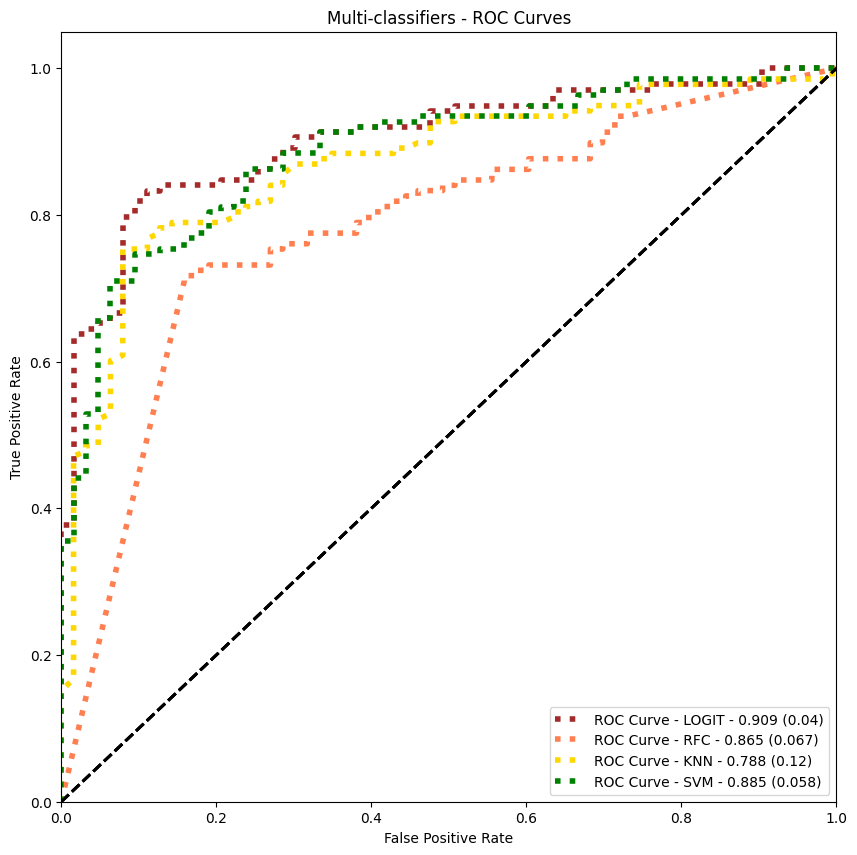

In [23]:
# import matplotlib.pyplot as plt
# plt.rcParams["figure.figsize"] = (10,10)
# plot_roc3(Y, conprobas,TEST2, colores = colores, nombres = clasificadores, title="Multi-classifiers - ROC Curves" )
# plt.show()


import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (10,10)
plot_roc3(Y, conprobas, colores = colores, nombres = clasificadores, title="Multi-classifiers - ROC Curves" )
plt.savefig("../results/aicode-ffu.png")
plt.show()

In [24]:
conjunto1.to_csv("../results/aicode-ffu.csv")
conjunto1

,accuracy,f1_score,precision,recall,specificity,roc_auc
LOGIT,0.836 (0.045),0.715 (0.09),0.785 (0.099),0.686 (0.163),0.907 (0.056),0.909 (0.04)
RFC,0.791 (0.07),0.624 (0.146),0.705 (0.163),0.583 (0.19),0.885 (0.065),0.865 (0.067)
KNN,0.741 (0.092),0.561 (0.169),0.63 (0.21),0.552 (0.21),0.826 (0.114),0.788 (0.12)
SVM,0.786 (0.044),0.57 (0.097),0.788 (0.159),0.46 (0.098),0.935 (0.05),0.885 (0.058)
